# Bank Classification Project - Modeling

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import pandas as pd
import numpy as np
from itertools import cycle
from scipy import interp

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
# Load in the preprocessed data set
bank_data = pickle.load(open('data/bank_data.pkl', 'rb'))

In [3]:
# Train test split
X, y = bank_data.iloc[:, 1:].values, bank_data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
# Bringing features on the same scale
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [5]:
# Baseline model
most_common = bank_data.y.mode()
count = pd.Series(y_test).value_counts()
baseline = count[0] / len(y_test)
print('Baseline accuracy: %.3f' % (baseline))

Baseline accuracy: 0.876


In [6]:
# Classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC()
}

results = []
names = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train_std,
                       y=y_train,
                       cv=10,
                       n_jobs=1)
    
    results.append(cv_scores)
    names.append(k)

    print(k)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('----------------')

Support Vector Machine
CV accuracy: 0.887 +/- 0.004
----------------
Logistic Regression
CV accuracy: 0.888 +/- 0.005
----------------
k-Nearest Neighbors
CV accuracy: 0.877 +/- 0.004
----------------
Gaussian Naive Bayes
CV accuracy: 0.705 +/- 0.009
----------------
Decision Tree
CV accuracy: 0.825 +/- 0.006
----------------


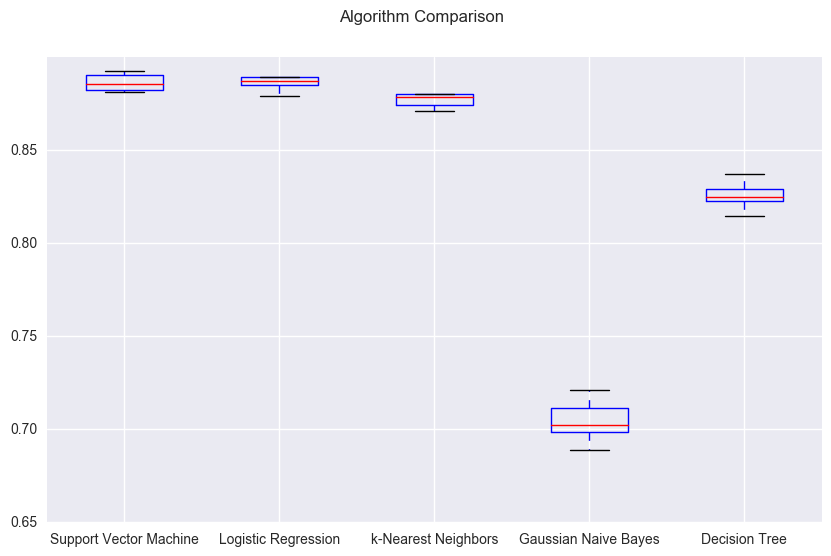

In [7]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

training SGD
training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG


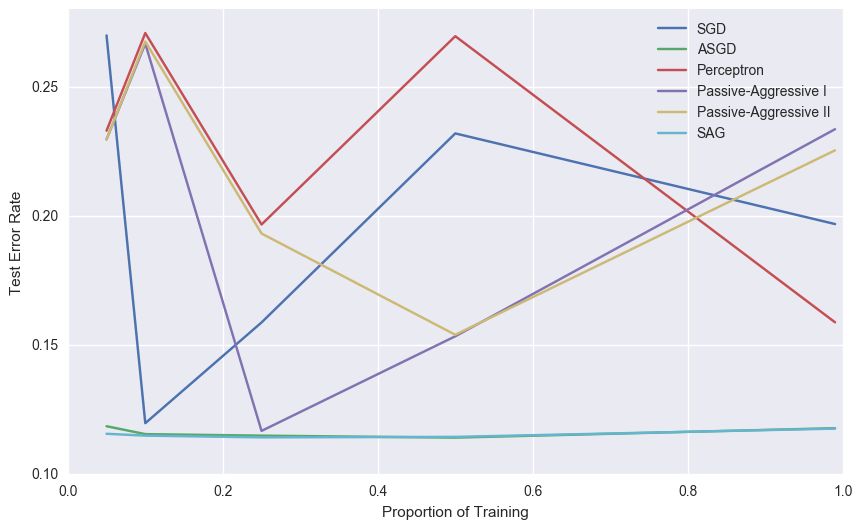

In [8]:
# Comparing online solvers
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20

classifiers = [
    ("SGD", SGDClassifier()),
    ("ASGD", SGDClassifier(average=True)),
    ("Perceptron", Perceptron()),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',
                                                         C=1.0)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',
                                                          C=1.0)),
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0]))
]

xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                                test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion of Training")
plt.ylabel("Test Error Rate")
plt.show()

I'm going to focus in on tuning the Logistic Regression classifier.

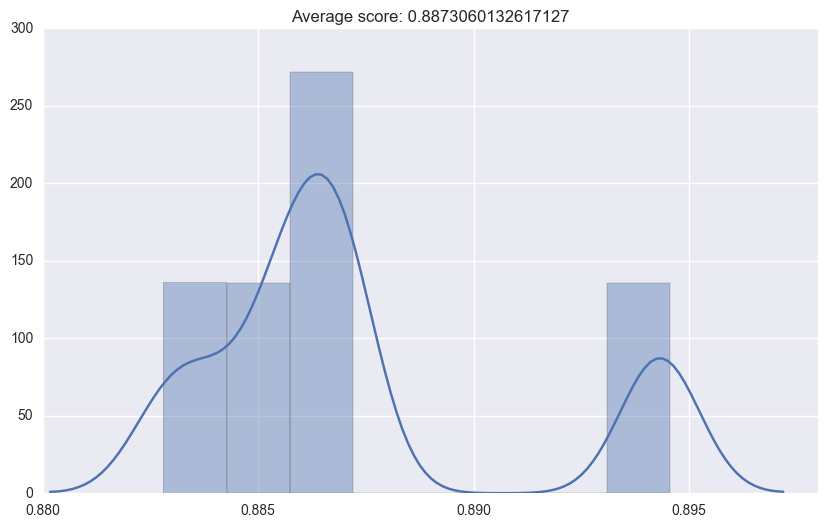

In [9]:
# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
cv_scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)));

In [10]:
# Use the learning curve to check for overfitting
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

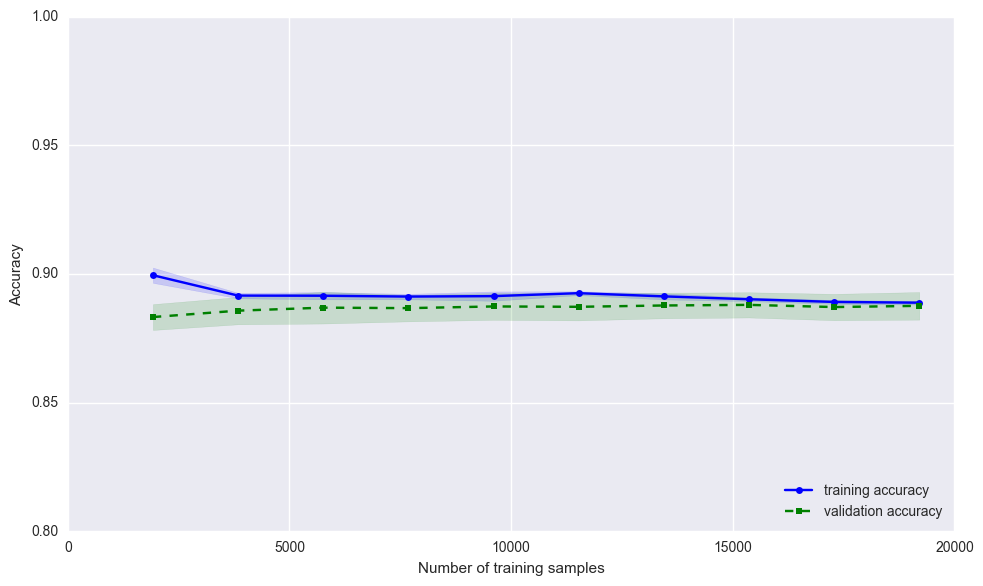

In [11]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./images/learning_curve.png', dpi=300)
plt.show()

In [12]:
# Examine hyperparameters
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

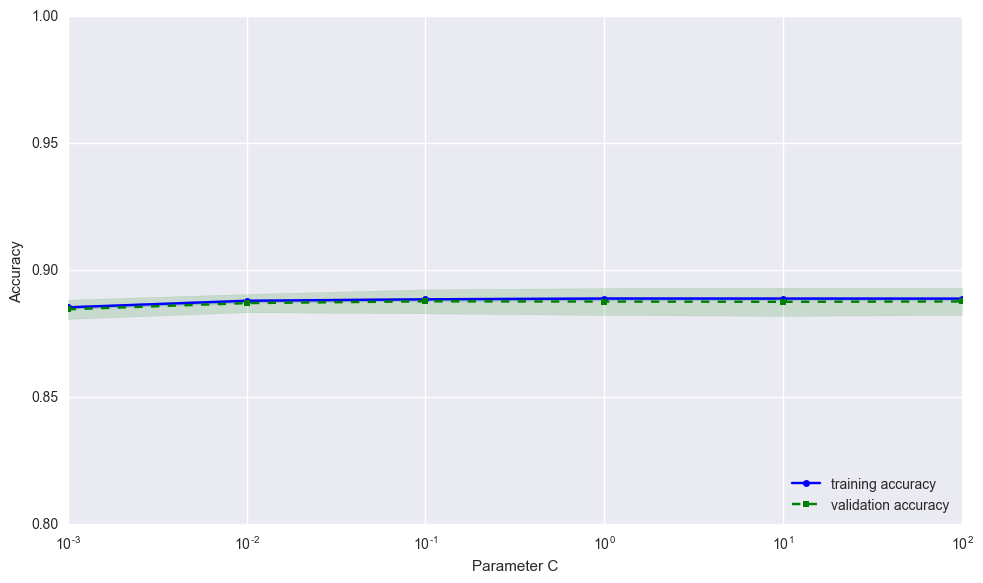

In [13]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid(True)
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.savefig('./images/validation_curve.png', dpi=300)
plt.show()

In [14]:
# Grid search with a stratified KFold
parameter_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cross_validation = StratifiedKFold(n_splits=10)

gs = GridSearchCV(pipe_lr,
                  param_grid=parameter_grid,
                  cv=cross_validation)

gs.fit(X_train, y_train)
print('Best score: {}'.format(gs.best_score_))
print('Best parameters: {}'.format(gs.best_params_))

Best score: 0.8877747059650438
Best parameters: {'clf__C': 0.1}


In [15]:
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
print('Test accuracy: %.3f' % clf.score(X_test_std, y_test))

Test accuracy: 0.891


In [16]:
# Confusion matrix
gs.fit(X_train_std, y_train)
y_pred = gs.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[7869  142]
 [ 857  279]]


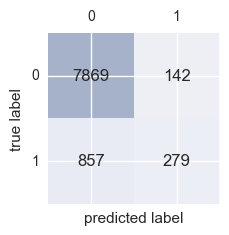

In [17]:
# Pretty confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('./images/confusion_matrix.png', dpi=300)
plt.show()

In [18]:
# Precision, recall and F1
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.663
Recall: 0.246
F1: 0.358


The moment you notice the imbalanced classes in EDA, you should re-iterate the hypothesis and focus in on the performance metric that matters the most. For our case, nothing serious happens if we guess wrong, but we want a **high recall**.

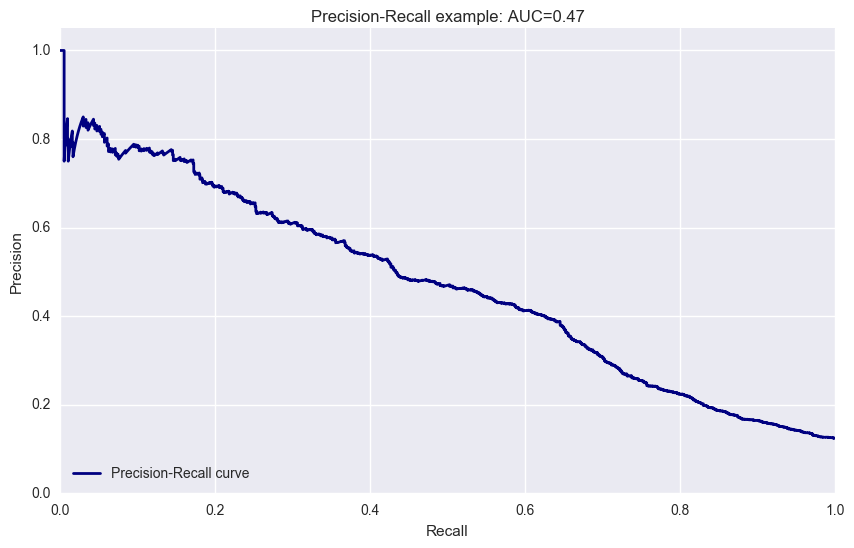

In [19]:
# Compute Precision-Recall and plot curve
y_score = LogisticRegression().fit(X_train_std, y_train).decision_function(X_test_std)

precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
lw = 2

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

In [20]:
# play around with decision thresholds
y_labels = LogisticRegression().fit(X_train_std, y_train).predict(X_test_std)
y_probas = LogisticRegression().fit(X_train_std, y_train).predict_proba(X_test_std)[:, 1]

In [21]:
# New labels
def update_labels(y, threshold=0.5):
    if y > threshold:
        label = 1
    else:
        label = 0

    return label

new_labels = [update_labels(y) for y in list(y_probas)]

In [22]:
new_labels == y_labels

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [23]:
# higher recall
new_labels = [update_labels(y, threshold=0.25) for y in list(y_probas)]

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=new_labels))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=new_labels))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=new_labels))

Precision: 0.453
Recall: 0.538
F1: 0.492


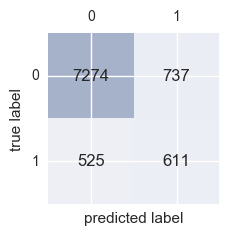

In [24]:
confmat = confusion_matrix(y_true=y_test, y_pred=new_labels)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

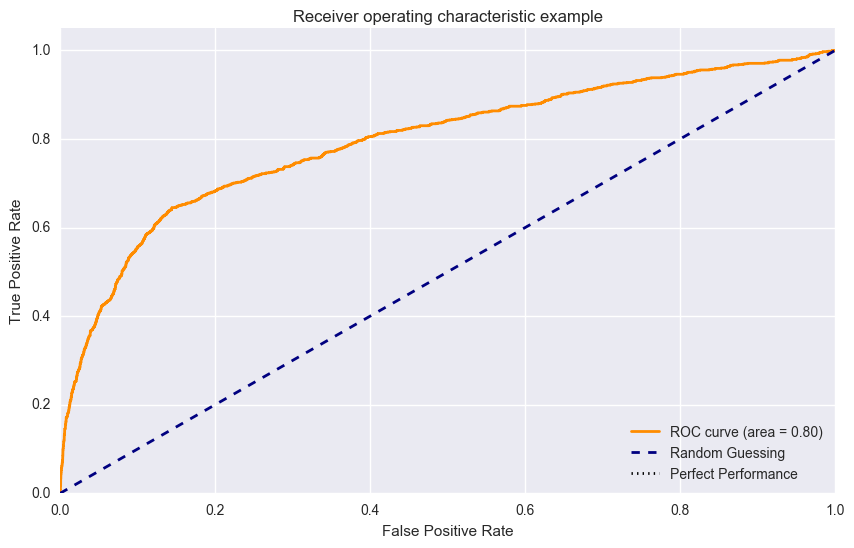

In [25]:
# Plot ROC curve
y_score = LogisticRegression().fit(X_train_std, y_train).decision_function(X_test_std)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random Guessing')
plt.plot([1, 1], [1, 1], color='black', lw=lw, linestyle=':', label='Perfect Performance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
# AUC vs. Accuracy
y_labels = LogisticRegression().fit(X_train_std, y_train).predict(X_test_std)
y_probas = LogisticRegression().fit(X_train_std, y_train).predict_proba(X_test_std)[:, 1]

print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_probas))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_labels))

ROC AUC: 0.795
Accuracy: 0.890


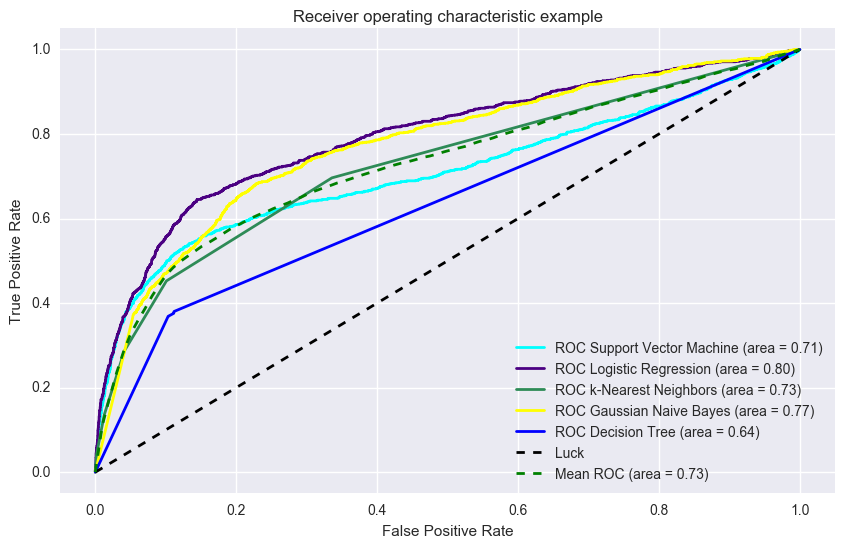

In [27]:
# Run classifiers and plot ROC curves
cv = StratifiedKFold(n_splits=6)
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True)
}

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])

i = 0
for (name, model), color in zip(models.items(), colors):
    probas_ = model.fit(X_train_std, y_train).predict_proba(X_test_std)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC %s (area = %0.2f)' % (name, roc_auc))

    i += 1
        
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= i
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

I will definitely need to do more feature engineering or use a crazy optimized algorithm like XGBoost in order to get >90% Accuracy. The pipeline is flexible enough to handle new data from additional campaigns when that data set is ready. The out-of-sample testing data accuracy score was extremely close to the cross-validation accuracy scores. Our model does not overfit and generalizes well for unseen data.

## Written Analysis

In [28]:
## See Repository README